## *Re-do* of Initial test runs - basic simulations, sparse fields where PSFs are known perfectly.

Here we add systematic 0.3-pixel offsets.

Original runs were in `26. algorithm shootout - detection-Copy3.ipynb`. These are re-run with more static sources, more variable sources, and accurate ~5-sigma transients.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 16
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

#import time
#time.sleep(600)

3


In [2]:
import diffimTests as dit
reload(dit)

sky = 300.
n_sources = 500
n_varSources = 50
varSourceFlux = 750.

global_psf1 = [1.6,1.6]   # old parameters
global_psf2 = [1.8,2.2]

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=global_psf1, psf2=global_psf2,
                         offset=[0.3,0.3], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                         varFlux2=np.repeat(varSourceFlux, n_varSources), variablesNearCenter=False,
                         theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                         sourceFluxRange=(400,100000), scintillation=0.,
                         seed=66, psfSize=21, avoidBorder=True)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

diffimTests.py:265: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (offset2[0]-starSize+1):(offset2[0]+starSize)] += tmp1
diffimTests.py:290: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  (offset2[0]-starSize+1):(offset2[0]+starSize)] += tmp


(0.93554527333762694, 17.566405874019967, -71.0, 1509.8670984857436)
(1.2943920708683796, 17.670161681239623, -71.0, 1011.8141209817709)
(300.93554527333754, 17.566405874019967, 229.0, 1809.8670984857436)
(301.29439207086835, 17.670161681239623, 229.0, 1311.8141209817709)


In [3]:
det = testObj.runTest()
print det

{'ZOGY': {'FP': 10, 'FN': 35, 'TP': 14}, 'ALstack': {'FP': 5, 'FN': 31, 'TP': 18}, 'SZOGY': {'FP': 7, 'FN': 43, 'TP': 7}, 'ALstack_noDecorr': {'FP': 5, 'FN': 30, 'TP': 19}}


Try some real tests!

In [4]:
# Default 10 sources with same flux
def runTest(flux, seed=66, sky=300., n_sources=500, n_varSources=50):
    #methods = ['ALstack', 'ZOGY', 'ZOGY_S', 'ALstack_noDecorr']
    testObj = dit.DiffimTest(imSize=(512,512), sky=sky, psf1=global_psf1, psf2=global_psf2,
                             offset=[0.3,0.3], psf_yvary_factor=0., sourceFluxDistrib='exponential',
                             varFlux2=np.repeat(flux, n_varSources), variablesNearCenter=False,
                             theta1=0., theta2=-45., im2background=0., n_sources=n_sources, 
                             sourceFluxRange=(400,100000), scintillation=0.,
                             seed=seed, psfSize=21, avoidBorder=True)
    det = testObj.runTest() #subtractMethods=methods) #, 'AL'])
    det['flux'] = flux
    return det

methods = ['ALstack', 'ZOGY', 'SZOGY', 'ALstack_noDecorr']

## Look at detection rates for 5.0-sigma sources.

In [5]:
inputs = [(f, seed) for f in [750.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults1 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=500, n_varSources=50) \
                                                     for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  8.1min finished


FN: 
ALstack             35.54
ALstack_noDecorr    33.25
SZOGY               35.94
ZOGY                35.15
dtype: float64
FP: 
ALstack              3.76
ALstack_noDecorr     4.30
SZOGY                4.24
ZOGY                21.58
dtype: float64
TP: 
ALstack             14.39
ALstack_noDecorr    16.66
SZOGY               13.98
ZOGY                14.76
dtype: float64


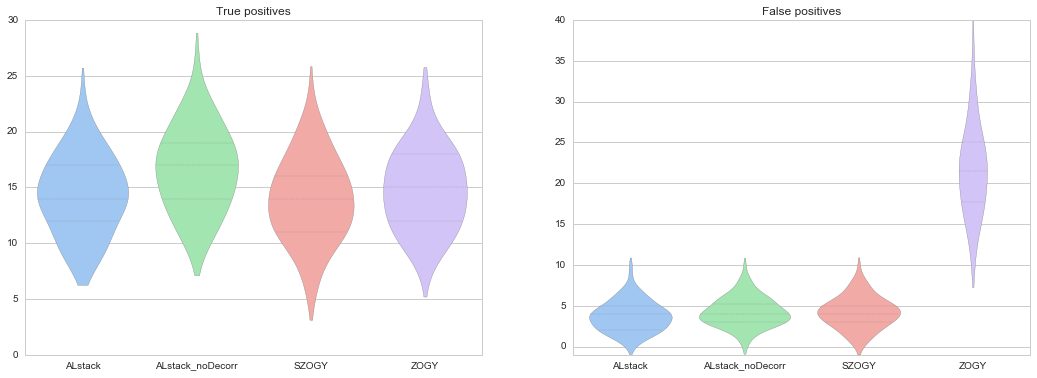

In [7]:
def plotResults(tr):
    FN = pd.DataFrame({key: np.array([t[key]['FN'] for t in tr]) for key in methods})
    FP = pd.DataFrame({key: np.array([t[key]['FP'] for t in tr]) for key in methods})
    TP = pd.DataFrame({key: np.array([t[key]['TP'] for t in tr]) for key in methods})
    print 'FN:', '\n', FN.mean()
    print 'FP:', '\n', FP.mean()
    print 'TP:', '\n', TP.mean()

    matplotlib.rcParams['figure.figsize'] = (18.0, 6.0)
    fig, axes = plt.subplots(nrows=1, ncols=2)

    sns.violinplot(data=TP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[0])
    axes[0].set_title('True positives')
    #axes[0].set_ylim((0, 31))
    sns.violinplot(data=FP, inner="quart", cut=True, linewidth=0.3, bw=0.5, ax=axes[1])
    axes[1].set_title('False positives')
    axes[1].set_ylim((-1, 40))
    
plotResults(testResults1)

## Look at detection rates for 3.33-sigma sources.

In [8]:
inputs = [(f, seed) for f in [500.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults2 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=500, n_varSources=50) \
                                                     for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.6min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  7.4min finished


FN: 
ALstack             48.46
ALstack_noDecorr    48.16
SZOGY               48.41
ZOGY                48.29
dtype: float64
FP: 
ALstack              1.88
ALstack_noDecorr     2.11
SZOGY                0.85
ZOGY                19.49
dtype: float64
TP: 
ALstack             1.46
ALstack_noDecorr    1.75
SZOGY               1.54
ZOGY                1.65
dtype: float64


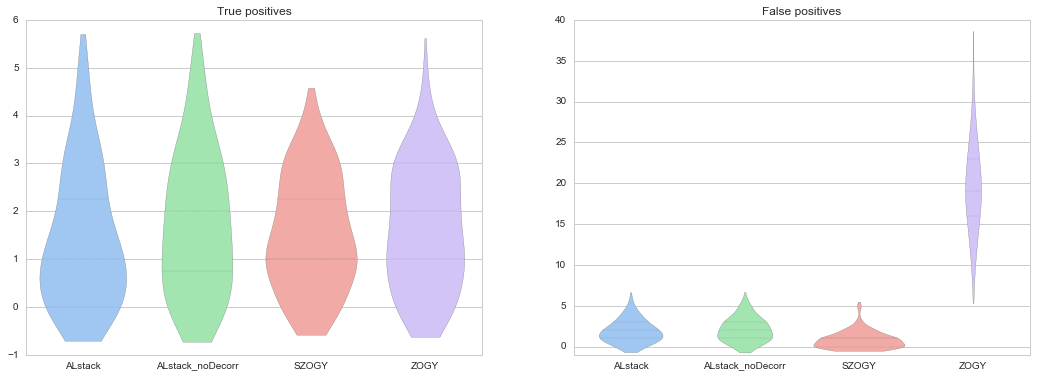

In [9]:
plotResults(testResults2)

## For fun, try some 10-sigma sources.

In [10]:
inputs = [(f, seed) for f in [1500.] for seed in np.arange(66, 166, 1)]
print len(inputs)
testResults3 = Parallel(n_jobs=num_cores, verbose=2)(delayed(runTest)(i[0], i[1], n_sources=500, n_varSources=50) \
                                                     for i in inputs)

100


[Parallel(n_jobs=3)]: Done  35 tasks      | elapsed:  2.9min
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:  8.3min finished


FN: 
ALstack             9.43
ALstack_noDecorr    5.88
SZOGY               6.81
ZOGY                7.10
dtype: float64
FP: 
ALstack              2.19
ALstack_noDecorr     2.35
SZOGY                2.31
ZOGY                19.10
dtype: float64
TP: 
ALstack             40.48
ALstack_noDecorr    44.02
SZOGY               43.10
ZOGY                42.80
dtype: float64


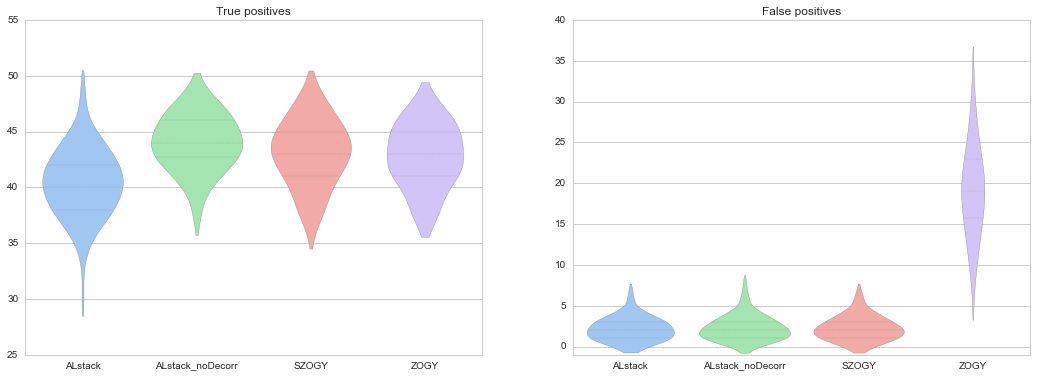

In [11]:
plotResults(testResults3)

In [12]:
import cPickle
import gzip
cPickle.dump((testResults1, testResults2, testResults3), gzip.GzipFile('testResults2_NEW.p.gz', 'wb'))